In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tensorflow import keras
from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
# from keras.applications import VGG19
# from keras.applications import ResNet50
# from keras.applications.inception_v3 import inception_v3
# from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import cv2
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pickle
from sklearn.utils import shuffle
import os
from PIL import Image
import seaborn as sns

In [26]:
# def image_index(label, Y_train):
#     count = 3
#     value = 1
#     Y_list = list(Y_train)
#     for x in range(len(Y_train)):
#         if(Y_list[x] == label):
#             print(x)
#             save_x = x
#             count -= 1
#         if(count == 0):
#             return x
# t = image_index(9, Y)
# image = X[t]
# plt.imshow(image)

In [27]:
def create_dataset(img_folder):
    img_data_array = []
    for file in sorted(os.listdir(img_folder)):
        image_path = os.path.join(img_folder, file)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (40, 20),interpolation = cv2.INTER_AREA)
        image = image.astype('float')
        image /= 255
        img_data_array.append(image)
    return np.array(img_data_array)

Text(0.5, 1.0, '3rd image')

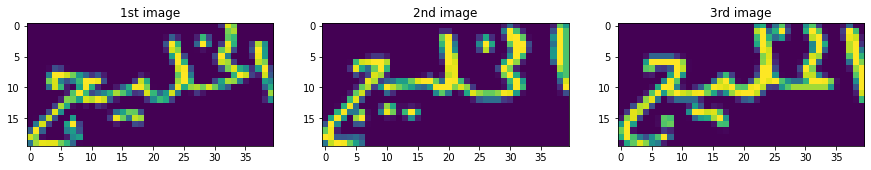

In [28]:
X = create_dataset("Images")

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 5))
ax1.imshow(X[26])
ax1.set_title("1st image")
ax2.imshow(X[28])
ax2.set_title("2nd image")
ax3.imshow(X[30])
ax3.set_title("3rd image")

#  Data Augmentation

In [29]:
def distortion(img):
    d_coef= np.array((0.15, 0.15, 0.1, 0.1, 0.05))

    # get the height and the width of the image
    h, w = img.shape[:2]

    # compute its diagonal
    f = (h ** 2 + w ** 2) ** 0.5

    # set the image projective to carrtesian dimension
    K = np.array([[f, 0, w / 2],
                  [0, f, h / 2],
                  [0, 0,   1  ]])

    d_coef = d_coef * np.random.random(5) # value
    d_coef = d_coef * (2 * (np.random.random(5) < 0.5) - 1) # sign

    # Generate new camera matrix from parameters
    M, _ = cv2.getOptimalNewCameraMatrix(K, d_coef, (w, h), 0, (w,h))

    dst = cv2.undistort(img, K, d_coef, None, M)
    return dst

# test1 = distortion(X[50])

# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 5))
# ax1.imshow(X[50])
# ax1.set_title("Original image")
# ax2.imshow(test1)
# ax2.set_title("distorted image")

In [30]:
def erodilator(img):
    kernel = np.ones((2,2),np.uint8)
    kernel_erode = np.ones((2,2),np.uint8)
    erosion = cv2.erode(img,kernel_erode,iterations = 1)
    dilation = cv2.dilate(img,kernel,iterations = 1)
    return erosion, dilation

erosion, dilation = erodilator(X[50])

# fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 5))
# ax1.imshow(X[50])
# ax1.set_title("Original image")
# ax2.imshow(erosion)
# ax2.set_title("erosion image")
# ax3.imshow(dilation)
# ax3.set_title("dilaiton image")

In [31]:
import imutils

def rotation(image):
    rot = imutils.rotate(image, angle=20)
    return rot

# rot = rotation(X[0])
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 5))
# ax1.imshow(X[0])
# ax1.set_title("Original image")
# ax2.imshow(rot)
# ax2.set_title("rotated image")

In [32]:
def shifter(image):
    tall, length = image.shape
    vect = int(tall/6)
    image_down = image[:tall-vect,:]
    empty_sp = np.zeros((vect,length))
    image_down = np.vstack((empty_sp, image_down))
    image1_up = image[vect:,:]
    image1_up = np.vstack((image1_up, empty_sp))
    return image1_up, image_down 

# img1, img2 = shifter(X[5])
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
# ax1.set_title("Original image")
# ax1.imshow(X[5])
# ax2.set_title("upper image")
# ax2.imshow(img1)
# ax3.set_title("downer image")
# ax3.imshow(img2)

In [33]:
def getNeighbors(img, pixel):
    return img[pixel[0] - 1 : pixel[0] + 2 , pixel[1] - 1 : pixel[1] + 2]

def getNeighborsSum(neighbors):
    neighbors = np.ravel(neighbors)
    sum = 0
    for i in neighbors:
        if i != 0 :
            sum = sum + 1
    
    return sum - 1

def getTransitions(neighbors):
    sequence = [neighbors[0,1], neighbors[0, 2], neighbors[1, 2], neighbors[2, 2], neighbors[2, 1], neighbors[2, 0], neighbors[1, 0], neighbors[0,0], neighbors[0,1]]

    transitions = 0
    for i in range(len(sequence) - 1):
        if sequence[i] == 0 and sequence[i+1] == 1:
            transitions = transitions + 1
    
    return transitions

def skelly(img):
    img = np.pad(img, (2,2), mode="constant", constant_values=(0,0))
    img[img != 0] = 1
    while(True):
        marked = np.ones(img.shape, np.uint8)
        changed = False
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i,j] == 0:
                    continue

                neighbors = getNeighbors(img, (i, j))
                if neighbors.shape != (3, 3):
                    continue
                
                sum = getNeighborsSum(neighbors)
                if not (sum <= 6 and sum >= 2):
                    continue 

                transitions = getTransitions(neighbors)
                if transitions != 1:
                    continue

                sequence = [neighbors[0,1], neighbors[0, 2], neighbors[1, 2], neighbors[2, 2], neighbors[2, 1], neighbors[2, 0], neighbors[1, 0], neighbors[0,0], neighbors[0,1]]
                neighbors2 = getNeighbors(img, (i-1, j))
                neighbors3 = getNeighbors(img, (i, j + 1))
                if sequence[0] * sequence[2] * sequence[6] != 0 and getTransitions(neighbors2) == 1 :
                    continue
                if sequence[0] * sequence[2] * sequence[4] != 0 and getTransitions(neighbors3) == 1:
                    continue

                changed = True
                marked[i,j] = 0

        img = np.multiply(img, marked)
        if not changed:
            return img

        
        
# skeleton  = skelly(X[12])
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
# ax1.set_title("Original image")
# ax1.imshow(X[12])
# ax2.set_title("Skeleton image")
# ax2.imshow(skeleton)

In [34]:
# def data_augmentation_image(image):
#     distorted_img =distortion(image)
#     erosion, dilation = erodilator(image)
#     image1_up, image_down = shifter(image)
#     rotated = rotation(image)

#     fig, axes = plt.subplots(2,3, figsize=(20, 10))
#     ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
#     ax1.set_title("rotated image")
#     ax1.imshow(rotated)
#     ax2.set_title("upper image")
#     ax2.imshow(image1_up)
#     ax3.set_title("downer image")
#     ax3.imshow(image_down)
#     ax4.set_title("eroted image")
#     ax4.imshow(erosion)
#     ax5.set_title("dialated image")
#     ax5.imshow(dilation)
#     ax6.set_title("distorted image")
#     ax6.imshow(distorted_img)
# data_augmentation_image(X[0])

In [3]:
def data_augmentation(X,Y):
    count = 1
    labels = []
    images = []
    for image,label in zip(X,Y):
        distorted_img =distortion(image)
        erosion, dilation = erodilator(image)
        image1_up, image_down = shifter(image)
        rotated = rotation(image)
        skeleton  = skelly(image)
        
        images.extend([distorted_img, erosion, dilation, image1_up, image_down, rotated, skeleton])
        labels.extend([label] * 7)

#         path = "Augmented_images/"
#         dist_name = str(count) + ".jpg"
#         erosion_name = str(count+1) + ".jpg"
#         dilation_name = str(count+2) + ".jpg"
#         image1_up_name = str(count+3) + ".jpg"
#         image_down_name = str(count+4) + ".jpg"
#         rotated_name = str(count+5) + ".jpg"

#         cv2.imwrite(path + dist_name, 255*distorted_img)
#         cv2.imwrite(path + erosion_name, 255*erosion)
#         cv2.imwrite(path + dilation_name, 255*dilation)
#         cv2.imwrite(path + image1_up_name, 255*image1_up)
#         cv2.imwrite(path + image_down_name, 255*image_down)
#         cv2.imwrite(path + rotated_name, 255*rotated)

#         count += 6
#     df.to_excel(path + "augmented.xlsx")
    df = pd.DataFrame(labels, columns=['Label'])
    return images, df

In [4]:
data = pd.read_excel("labels.xlsx", names=["Label"],header=None)
Y = data.Label
data.iloc[[26, 28, 30]]

NameError: name 'pd' is not defined

In [37]:
images_augmented, df_augmented = data_augmentation(X,Y)

In [38]:
X_final = np.concatenate((X, images_augmented))
frames = [df, df_augmented]
data = pd.concat(frames)
Y_final = data.Label

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(7, 6))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.countplot(ax=ax1, x= Y_train.Label)
ax1.set_title("Train distibution")
sns.countplot(ax=ax2, x= Y_test.Label)
ax2.set_title("Test Distribution")
plt.show()

In [14]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
Y_train_categories = label_encoder.fit_transform(Y_train)
label_encoder = preprocessing.LabelEncoder()
Y_test_categories = label_encoder.fit_transform(Y_test)

In [15]:
Y_train_categories = tf.keras.utils.to_categorical(Y_train_categories, 21)
Y_test_categories = tf.keras.utils.to_categorical(Y_test_categories, 21)

In [53]:
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()



pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(190, 320, 3),
                                                  pooling='max',
                                                  classes=21,
                                                  weights="imagenet")

for layer in pretrained_model.layers:
    layer.trainable = False

#Transfer layer
model.add(pretrained_model)
model.add(Flatten())

# #output layer
model.add(Dense(units=21, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 21)                43029     
                                                                 
Total params: 23,630,741
Trainable params: 43,029
Non-trainable params: 23,587,712
_________________________________________________________________


In [54]:
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()
#Conv layer 1
model.add(Conv2D(filters=60, kernel_size = (3, 3), padding = "same", strides=(1,2), input_shape=(190, 320, 1),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Conv layer 2
model.add(Conv2D(filters=30, kernel_size = (3, 3), padding = "same", strides=(1,2),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Conv layer 3
model.add(Conv2D(filters=20, kernel_size = (3, 3), padding = "same", strides=(1,2),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Conv layer 4
model.add(Conv2D(filters=20, kernel_size = (3, 3), padding = "same", strides=(1,2),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Flatten layer
model.add(Flatten())

#Fully connected layers
model.add(Dense(units = 256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(units = 21, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 190, 160, 60)      600       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 95, 80, 60)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 95, 40, 30)        16230     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 47, 20, 30)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 47, 10, 20)        5420      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 5, 20)       

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)

In [55]:
epochs = 100
batch_size = 32

In [56]:
#Training
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [7]:
from keras.callbacks import EarlyStopping
history = model.fit(X_train,
                    Y_train_categories,
                    validation_split=0.2,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=1)

NameError: name 'model' is not defined

In [8]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

count = range(len(train_accuracy))
plt.plot(count, train_accuracy, label='Trainnig accuracy')
plt.plot(count, train_loss, label='Trainning Loss')
plt.title('epochs vs Training Loss')
plt.legend()

train_accuracy = history.history['val_accuracy']
train_loss = history.history['val_loss']

count = range(len(train_accuracy))
plt.plot(count, train_accuracy, label='Val accuracy')
plt.plot(count, train_loss, label='Val Loss')
plt.title('epochs vs Training Loss')
plt.legend()

NameError: name 'history' is not defined

In [25]:
###Check_point
# model.save("Check_point2.h5")

#Load_checkpoint
model=load_model('Normal (no augment).h5')

In [26]:
score = model.evaluate(X_test, Y_test_categories, verbose=0)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

Test set
  Loss: 1.45
  Accuracy: 0.73


In [234]:
# !pip install arabic_reshaper
import arabic_reshaper

Y_pred = model.predict(X_test)
predicted_classes = np.argmax(Y_pred, axis=1)
expected_classes = np.argmax(Y_test_categories, axis=1)

Arabic_words = []
Arabic_words.append("الرضّاع")
Arabic_words.append("الخليج")
Arabic_words.append("نقة")
Arabic_words.append("شعّال")
Arabic_words.append("مارث")
Arabic_words.append("الشمّاخ")
Arabic_words.append("زنّوش")
Arabic_words.append("الدخّانية")
Arabic_words.append("الفايض")
Arabic_words.append("أكّودة")
Arabic_words.append("سبعة آبار")
Arabic_words.append("سيدي ابراهيم الزهّار")
Arabic_words.append("المرناقية 20 مارس")
Arabic_words.append("شتاوة صحراوي")
Arabic_words.append("الفكّة")
Arabic_words.append("أوتيك")
Arabic_words.append("الفحص")
Arabic_words.append("الشرايع")
Arabic_words.append("حي الإنطلاقة")
Arabic_words.append("شواط")
Arabic_words.append("حي التضامن")



for word in range(len(Arabic_words)):
    Arabic_words[word] = arabic_reshaper.reshape(Arabic_words[word])
    Arabic_words[word] = Arabic_words[word][::-1]

labels = Arabic_words 

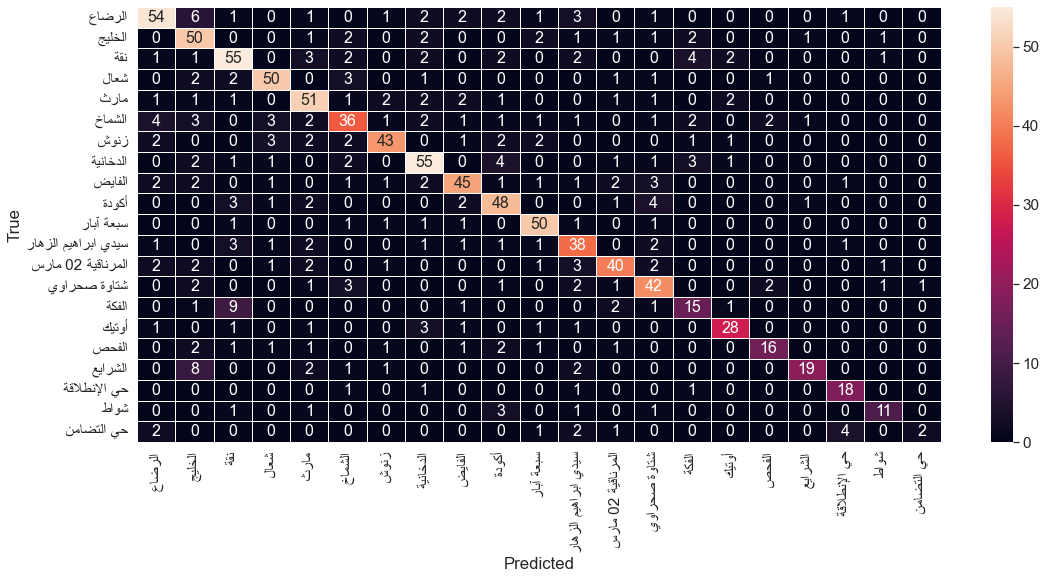

In [235]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

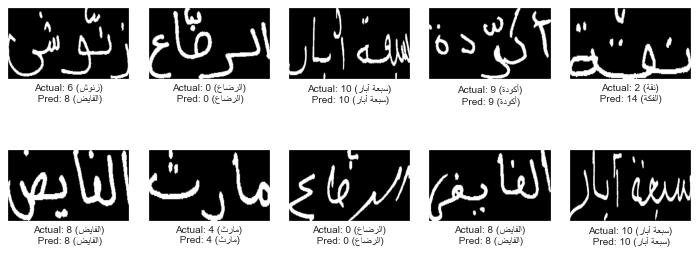

In [236]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    
    img_index = np.random.randint(0, 150)
    plt.imshow(X_test[img_index], cmap=plt.cm.gray)
    actual_label  = np.argmax(Y_test_categories[img_index])
    predicted_label = predicted_classes[img_index]

    plt.xlabel("Actual: {} ({})\n Pred: {} ({})".format(
        actual_label, labels[actual_label], predicted_label, labels[predicted_label]
    ), fontsize=10)
    
plt.tight_layout()
plt.show()